In [1]:
#import required python classes and packages
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load and display smart grid power consumption dataset
dataset = pd.read_csv("Dataset/smart_grid_dataset.csv")
dataset

,Timestamp,Voltage (V),Current (A),Power Consumption (kW),Reactive Power (kVAR),Power Factor,Solar Power (kW),Wind Power (kW),Grid Supply (kW),Voltage Fluctuation (%),Overload Condition,Transformer Fault,Temperature (°C),Humidity (%),Electricity Price (USD/kWh),Predicted Load (kW)
0,2024-01-01 00:00:00,232.483571,5.124673,NaN,0.399029,0.907766,46.614845,26.399566,0.0,1.055937,0,0,17.842767,64.523353,0.416156,1.233158
1,2024-01-01 00:15:00,229.308678,22.213519,NaN,1.248030,0.831813,6.907170,18.555011,0.0,-3.910902,1,0,18.753698,49.671940,0.492334,5.247824
2,2024-01-01 00:30:00,233.238443,46.132217,NaN,2.790464,0.999005,15.477640,12.905025,0.0,-0.197551,0,0,16.719325,48.472769,0.427785,10.580278
3,2024-01-01 00:45:00,237.615149,47.648972,NaN,1.956965,0.896462,35.746398,28.937129,0.0,2.671921,0,0,15.364564,75.766776,0.487953,11.225946
4,2024-01-01 01:00:00,228.829233,7.410166,NaN,0.624718,0.870681,27.555038,14.184648,0.0,3.826937,0,0,38.760333,61.384213,0.290078,1.696639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2024-01-26 23:45:00,234.066026,15.120568,3.539211,1.140109,0.978714,3.289823,10.854560,0.0,1.474742,0,0,38.138105,44.265485,0.498370,3.611386
2496,2024-01-27 00:00:00,228.605185,19.216876,4.393077,1.535380,0.841077,43.699040,5.904928,0.0,-1.172893,1,0,17.125772,70.356668,0.114237,4.201499
2497,2024-01-27 00:15:00,228.601199,31.790970,7.267454,1.397275,0.915190,6.706330,24.667879,0.0,4.250795,0,0,37.294815,57.626277,0.364132,7.118638
2498,2024-01-27 00:30:00,233.951859,8.785781,2.055450,0.489854,0.864128,31.966137,11.560628,0.0,4.322906,0,0,12.001252,42.701103,0.209687,1.960994


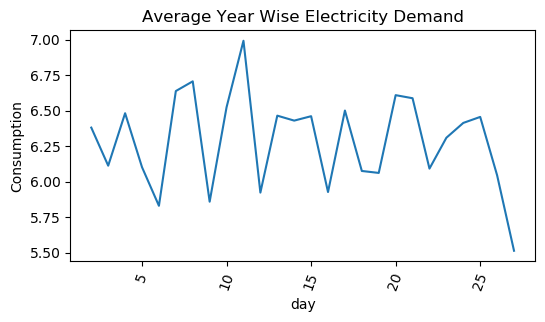

In [3]:
#converting date to day format
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])
dataset['day'] = dataset['Timestamp'].dt.day
#visualizing average energy consumption day wise
data = dataset.groupby(["day"])['Power Consumption (kW)'].mean().sort_values(ascending=False).reset_index(name='Consumption')
plt.figure(figsize=(6, 3))
sns.lineplot(data=data, x="day", y="Consumption")
plt.xticks(rotation=70)
plt.title("Average Year Wise Electricity Demand")
plt.show()

In [4]:
#function to apply fusion matrix on smart grid data to handle missing and noise values and then reconstruct new data
def fusionMatrixCompletion(matrices):
    num_matrices = matrices.shape[1]
    rows, cols = matrices.shape
    completed_matrix = matrices.copy()
    indices = np.where(np.isnan(completed_matrix))
    for row, col in zip(*indices):
        completed_matrix[row,col] = np.mean(completed_matrix[~np.isnan(completed_matrix[:,col]), col]) 
    return completed_matrix

In [5]:
#finding and displaying count of missing or null values
dataset.isnull().sum()

Timestamp                        0
Voltage (V)                      0
Current (A)                      0
Power Consumption (kW)         100
Reactive Power (kVAR)            0
Power Factor                     0
Solar Power (kW)                 0
Wind Power (kW)                  0
Grid Supply (kW)                 0
Voltage Fluctuation (%)          0
Overload Condition               0
Transformer Fault                0
Temperature (°C)                 0
Humidity (%)                     0
Electricity Price (USD/kWh)      0
Predicted Load (kW)              0
day                              0
dtype: int64

In [6]:
#applying fusion matrix on noisy data to remove noise and misisng values
dataset.drop(['day', 'Timestamp', 'Predicted Load (kW)'], axis = 1,inplace=True) #removing irrelevant columns
columns = dataset.columns
dataset = dataset.values
# Perform fusion matrix completion
completed_matrix = fusionMatrixCompletion(dataset)
completed_matrix = pd.DataFrame(completed_matrix, columns=columns)
completed_matrix.isnull().sum()

Voltage (V)                    0
Current (A)                    0
Power Consumption (kW)         0
Reactive Power (kVAR)          0
Power Factor                   0
Solar Power (kW)               0
Wind Power (kW)                0
Grid Supply (kW)               0
Voltage Fluctuation (%)        0
Overload Condition             0
Transformer Fault              0
Temperature (°C)               0
Humidity (%)                   0
Electricity Price (USD/kWh)    0
dtype: int64

In [8]:
print(dataset.shape)
print(completed_matrix.shape)

(2500, 14)
(2500, 14)


In [9]:
#function to apply dbscan clustreing along with GMM to handle overlapping of clusters and hidden structures
def dbscanGMM(dataset, dbscan_eps=0.5, dbscan_min_samples=5, gmm_n_components=3, gmm_covariance_type='full'):
    # 1. DBSCAN Clustering for anomaaly detection
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    cluster_labels = dbscan.fit_predict(dataset)
    # 2. GMM modelling overlapping clusters
    anomaly_scores = np.zeros(len(dataset))
    unique_labels = np.unique(cluster_labels)
    for label in unique_labels:
        if label == -1:  
            continue
        cluster_data = dataset[cluster_labels == label]

        if len(cluster_data) < gmm_n_components:
            # Handle cases where a cluster has fewer points than GMM components
            anomaly_scores[cluster_labels == label] = 0.0 #or some high number, depending on context.
            continue
        try:
            gmm = GaussianMixture(n_components=gmm_n_components, covariance_type=gmm_covariance_type, random_state=0).fit(cluster_data)
            anomaly_scores[cluster_labels == label] = -gmm.score_samples(cluster_data) # uncover hierarchical hidden structures
        except ValueError as e:
            print(f"GMM failed for cluster {label}: {e}")
            anomaly_scores[cluster_labels == label] = np.max(anomaly_scores) if np.max(anomaly_scores) >0 else 1 # Assign high score if GMM fails.
    anomaly_scores[cluster_labels == -1] = np.max(anomaly_scores) if np.max(anomaly_scores) >0 else 1 #Assign high score to DBSCAN anomalies.

    return anomaly_scores, cluster_labels


In [10]:
data_scaled = completed_matrix.values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_scaled)#dataset normalization
pca = PCA(n_components=2)
data_scaled = pca.fit_transform(data_scaled)#dataset dimension reduction using PCA
# Perform anomaly detection
anomaly_scores, cluster_labels = dbscanGMM(data_scaled, dbscan_eps=1.7, dbscan_min_samples=2, gmm_n_components=3)
#Evaluate cluster quality (excluding noise points)
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[cluster_labels != -1] = True
labels_core = cluster_labels[core_samples_mask]
print(f"Silhouette Score: {silhouette_score(data_scaled[core_samples_mask], labels_core)}")
print("Total Generated Clusters = "+str(len(np.unique(cluster_labels))))

Silhouette Score: 0.7659021795656014
Total Generated Clusters = 3


In [23]:
print(np.unique(cluster_labels, return_counts=True))

(array([0, 1, 2], dtype=int64), array([2490,    8,    2], dtype=int64))


In [26]:
for i in range(len(anomaly_scores)):
    if anomaly_scores[i] > 13.59:
        print(str(dataset[i])+"=== "+str(i))

[237.32824384  30.45463791          nan   2.71619107   0.86771056
   1.83213172   2.76782225   2.62779177   0.46935286   0.
   0.          34.58373786  62.51083658   0.40481001]=== 20
[ 2.20406144e+02  2.69503332e+01  5.94001902e+00  1.33022745e+00
  9.52067450e-01  5.51349284e-01  1.30910194e+00  4.07956780e+00
 -2.77119525e+00  0.00000000e+00  0.00000000e+00  1.58573900e+01
  5.88022710e+01  2.10377744e-01]=== 110
[228.95938875  49.65082038  11.36802149   4.25436474   0.96405558
   7.91110607   2.22169471   1.23522071  -2.53320695   0.
   0.          33.23875765  52.53346742   0.45645119]=== 290
[ 2.27767832e+02  4.68976836e+01  1.06817837e+01  3.67706261e+00
  8.16913559e-01  2.04833974e+00  7.09539233e+00  1.53805164e+00
 -3.99345254e+00  0.00000000e+00  0.00000000e+00  2.31104210e+01
  4.20202587e+01  1.03584918e-01]=== 918
[ 2.33213614e+02  3.05889444e+01  7.13375827e+00  9.12008176e-01
  9.96904250e-01  3.56032562e+00  2.62127819e-01  3.31130483e+00
 -1.37618748e+00  0.00000000e

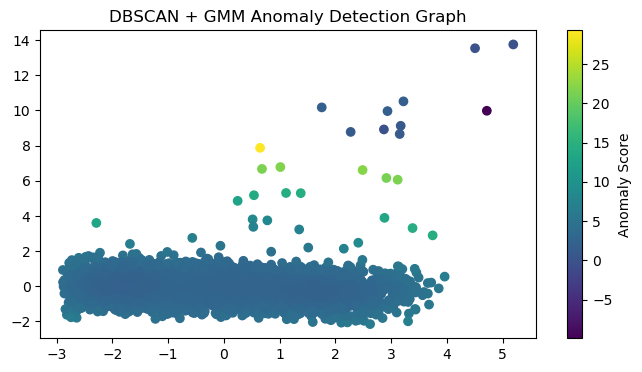

In [40]:
# displaying graph with anomaly score
plt.figure(figsize=(8, 4))
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=anomaly_scores, cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.title('DBSCAN + GMM Anomaly Detection Graph')
plt.show()

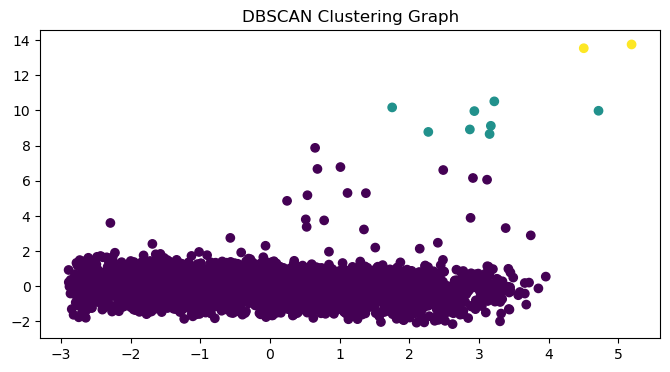

In [41]:
#displaying clustering graph with points closer to one and other will be in same colour cluster
plt.figure(figsize=(8,4))
plt.scatter(data_scaled[:,0], data_scaled[:, 1], c=cluster_labels, cmap='viridis')
plt.title('DBSCAN Clustering Graph')
plt.show()